In [16]:
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression

In [17]:
# Define the base path for the MMASH dataset
base_path = '/Users/callumclynes/MDM3 - 2/MMASH'

# Path to DataPaper folder
datapaper_path = os.path.join(base_path, 'DataPaper')

# Dictionary to store questionnaires for each user
questionnaires = {}

# Get user folders and sort them numerically
user_folders = [f for f in os.listdir(datapaper_path) if f.startswith('user_')]
user_folders.sort(key=lambda x: int(x.replace('user_', '')))

# Iterate through user folders in numerical order
for folder in user_folders:
    user_path = os.path.join(datapaper_path, folder)
    questionnaire_file = os.path.join(user_path, 'questionnaire.csv')
    
    # Check if questionnaire.csv exists
    if os.path.exists(questionnaire_file):
        df = pd.read_csv(questionnaire_file)
        df.insert(0, 'user', folder)  # Add user column at the start
        questionnaires[folder] = df
        #print(f"Loaded questionnaire for {folder}")

# Combine all questionnaires into one dataframe
all_questionnaires = pd.concat(questionnaires.values(), ignore_index=True)
print(f"\nCombined dataframe shape: {all_questionnaires.shape}")

print(all_questionnaires.head())


Combined dataframe shape: (22, 21)
     user  Unnamed: 0   MEQ  STAI1  STAI2  Pittsburgh  Daily_stress  \
0  user_1           0  47.0   41.0   43.0         5.0          23.0   
1  user_2           0  52.0   24.0   39.0         7.0          26.0   
2  user_3           0  59.0   27.0   27.0         8.0          11.0   
3  user_4           0  60.0   28.0   40.0         4.0          10.0   
4  user_5           0  52.0   54.0   47.0         8.0          41.0   

   BISBAS_bis  BISBAS_reward  BISBAS_drive  ...  panas_pos_10  panas_pos_14  \
0        22.0           21.0          14.0  ...          21.0          17.0   
1        26.0           21.0          12.0  ...          37.0          32.0   
2        19.0           18.0          12.0  ...          35.0          34.0   
3        20.0           17.0          13.0  ...          30.0          27.0   
4        25.0           23.0          14.0  ...          30.0          25.0   

   panas_pos_18  panas_pos_22  panas_pos_9+1  panas_neg_10  pa

In [18]:
# Define the base path for the MMASH dataset
base_path = '/Users/callumclynes/MDM3 - 2/MMASH'

# Path to DataPaper folder
datapaper_path = os.path.join(base_path, 'DataPaper')

# List to store combined data for each user
user_data_list = []

# Get user folders and sort them numerically
user_folders = [f for f in os.listdir(datapaper_path) if f.startswith('user_')]
user_folders.sort(key=lambda x: int(x.replace('user_', '')))

# Iterate through user folders in numerical order
for folder in user_folders:
    user_path = os.path.join(datapaper_path, folder)
    questionnaire_file = os.path.join(user_path, 'questionnaire.csv')
    saliva_file = os.path.join(user_path, 'saliva.csv')
    
    # Check if both files exist
    if os.path.exists(questionnaire_file) and os.path.exists(saliva_file):
        # Read questionnaire
        df_quest = pd.read_csv(questionnaire_file)
        
        # Read saliva
        df_saliva = pd.read_csv(saliva_file)
        
        # Pivot saliva data: convert rows (before sleep/wake up) to columns
        # Assuming saliva.csv has columns like: time_point, cortisol, melatonin, etc.
        df_saliva_pivot = df_saliva.set_index(df_saliva.columns[0])  # First column is time point
        
        # Flatten the pivoted data into a single row
        saliva_dict = {}
        for time_point in df_saliva_pivot.index:
            for col in df_saliva_pivot.columns:
                saliva_dict[f"{col}_{time_point}"] = df_saliva_pivot.loc[time_point, col]
        
        # Convert to DataFrame with one row
        df_saliva_flat = pd.DataFrame([saliva_dict])
        
        # Combine questionnaire with flattened saliva data
        df_combined = pd.concat([df_quest.reset_index(drop=True), df_saliva_flat.reset_index(drop=True)], axis=1)
        df_combined.insert(0, 'user', folder)
        
        user_data_list.append(df_combined)

# Combine all user data into one dataframe
all_data = pd.concat(user_data_list, ignore_index=True)
print(f"\nCombined dataframe shape: {all_data.shape}")
print(all_data.head())


Combined dataframe shape: (21, 27)
     user  Unnamed: 0   MEQ  STAI1  STAI2  Pittsburgh  Daily_stress  \
0  user_1           0  47.0   41.0   43.0         5.0          23.0   
1  user_2           0  52.0   24.0   39.0         7.0          26.0   
2  user_3           0  59.0   27.0   27.0         8.0          11.0   
3  user_4           0  60.0   28.0   40.0         4.0          10.0   
4  user_5           0  52.0   54.0   47.0         8.0          41.0   

   BISBAS_bis  BISBAS_reward  BISBAS_drive  ...  panas_neg_14  panas_neg_18  \
0        22.0           21.0          14.0  ...          13.0          13.0   
1        26.0           21.0          12.0  ...          10.0          16.0   
2        19.0           18.0          12.0  ...          12.0          11.0   
3        20.0           17.0          13.0  ...          13.0          15.0   
4        25.0           23.0          14.0  ...          17.0          17.0   

   panas_neg_22  panas_neg_9+1     SAMPLES_1  Cortisol NORM_1 

In [19]:
# *** DOES IT MAKE SENSE DOING MORNING TO NIGHT FOR BOTH OR NUGHT TO MORNING FOR MELA
all_data['d_cortisol'] = all_data['Cortisol NORM_2'] - all_data['Cortisol NORM_1']
all_data['d_melatonin'] = all_data['Melatonin NORM_2'] - all_data['Melatonin NORM_1']

# View the results
print(all_data.head(23))



       user  Unnamed: 0   MEQ  STAI1  STAI2  Pittsburgh  Daily_stress  \
0    user_1           0  47.0   41.0   43.0         5.0          23.0   
1    user_2           0  52.0   24.0   39.0         7.0          26.0   
2    user_3           0  59.0   27.0   27.0         8.0          11.0   
3    user_4           0  60.0   28.0   40.0         4.0          10.0   
4    user_5           0  52.0   54.0   47.0         8.0          41.0   
5    user_6           0  48.0   32.0   47.0         9.0          41.0   
6    user_7           0  46.0   33.0    0.0         7.0          69.0   
7    user_8           0  64.0   32.0   39.0         3.0          74.0   
8    user_9           0  44.0   36.0   41.0         9.0          38.0   
9   user_10           0  38.0   39.0   46.0         4.0          14.0   
10  user_11           0  38.0   36.0   43.0         7.0          17.0   
11  user_12           0  50.0   27.0   33.0         4.0          48.0   
12  user_13           0  48.0   30.0   43.0        

In [20]:
# Start with all columns
X = all_data.copy()

# Remove columns you don't need
columns_to_remove = ['user', 'Unnamed: 0', 'SAMPLES_1', 'SAMPLES_2',
                     'Cortisol NORM_1', 'Cortisol NORM_2', 
                     'Melatonin NORM_1', 'Melatonin NORM_2',
                     'd_cortisol', 'd_melatonin']
X = X.drop(columns=columns_to_remove)

# View remaining columns
print(f"Features included: {X.columns.tolist()}")
print(f"Shape: {X.shape}")


y_cortisol = all_data['d_cortisol']
y_melatonin = all_data['d_melatonin']

# Use IterativeImputer - predicts missing values using other features
imputer = IterativeImputer(random_state=42, max_iter=10)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Verify no NaN values remain
print(f"NaN values after imputation: {X_imputed.isna().sum().sum()}")

# Update X to use imputed version
X = X_imputed

# Select top 8 features for cortisol
k_features = 5
selector_c = SelectKBest(f_regression, k=k_features)
X_selected_c = selector_c.fit_transform(X, y_cortisol)
selected_features_c = X.columns[selector_c.get_support()].tolist()
print(f"\n=== Selected Features for Cortisol ===")
print(selected_features_c)

# Select top 8 features for melatonin
selector_m = SelectKBest(f_regression, k=k_features)
X_selected_m = selector_m.fit_transform(X, y_melatonin)
selected_features_m = X.columns[selector_m.get_support()].tolist()
print(f"\n=== Selected Features for Melatonin ===")
print(selected_features_m)

# Create dataframes with selected features
X_selected_c_df = pd.DataFrame(X_selected_c, columns=selected_features_c)
X_selected_m_df = pd.DataFrame(X_selected_m, columns=selected_features_m)

# Split data with selected features
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_selected_c_df, y_cortisol, test_size=0.2, random_state=42)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_selected_m_df, y_melatonin, test_size=0.2, random_state=42)

# Train cortisol model with selected features
model_cortisol = LinearRegression()
model_cortisol.fit(X_train_c, y_train_c)

# Train melatonin model with selected features
model_melatonin = LinearRegression()
model_melatonin.fit(X_train_m, y_train_m)

# Evaluate cortisol model
y_pred_c = model_cortisol.predict(X_test_c)
r2_c = r2_score(y_test_c, y_pred_c)
rmse_c = np.sqrt(mean_squared_error(y_test_c, y_pred_c))

print("\n=== Cortisol Model (with feature selection) ===")
print(f"R² Score: {r2_c:.4f}")
print(f"RMSE: {rmse_c:.4f}")

# Evaluate melatonin model
y_pred_m = model_melatonin.predict(X_test_m)
r2_m = r2_score(y_test_m, y_pred_m)
rmse_m = np.sqrt(mean_squared_error(y_test_m, y_pred_m))

print("\n=== Melatonin Model (with feature selection) ===")
print(f"R² Score: {r2_m:.4f}")
print(f"RMSE: {rmse_m:.4f}")



Features included: ['MEQ', 'STAI1', 'STAI2', 'Pittsburgh', 'Daily_stress', 'BISBAS_bis', 'BISBAS_reward', 'BISBAS_drive', 'BISBAS_fun', 'panas_pos_10', 'panas_pos_14', 'panas_pos_18', 'panas_pos_22', 'panas_pos_9+1', 'panas_neg_10', 'panas_neg_14', 'panas_neg_18', 'panas_neg_22', 'panas_neg_9+1']
Shape: (21, 19)
NaN values after imputation: 0

=== Selected Features for Cortisol ===
['BISBAS_bis', 'panas_pos_10', 'panas_pos_9+1', 'panas_neg_14', 'panas_neg_9+1']

=== Selected Features for Melatonin ===
['STAI1', 'BISBAS_reward', 'BISBAS_fun', 'panas_pos_22', 'panas_neg_18']

=== Cortisol Model (with feature selection) ===
R² Score: 0.1469
RMSE: 0.0732

=== Melatonin Model (with feature selection) ===
R² Score: 0.4197
RMSE: 0.0000



=== CORRELATION ANALYSIS ===
(More appropriate for n=21 samples)

=== TOP CORRELATIONS WITH CORTISOL CHANGE ===
      Feature  Correlation  P-value Significant
panas_neg_9+1     0.404257 0.069127          No
 panas_pos_10     0.398686 0.073420          No
 panas_neg_14    -0.375281 0.093667          No
panas_pos_9+1     0.356160 0.113043          No
   BISBAS_bis     0.342556 0.128489          No
 panas_pos_14     0.313285 0.166711          No
   Pittsburgh     0.264032 0.247466          No
   BISBAS_fun    -0.259441 0.256087          No
        STAI1    -0.238062 0.298725          No
 panas_pos_22     0.229793 0.316317          No

=== SIGNIFICANT CORRELATIONS WITH CORTISOL (p < 0.05) ===
No statistically significant correlations found

=== TOP CORRELATIONS WITH MELATONIN CHANGE ===
      Feature  Correlation  P-value Significant
   BISBAS_fun    -0.437620 0.047257         Yes
 panas_neg_18    -0.364237 0.104533          No
        STAI1    -0.326410 0.148708          No
BISBAS_rewar

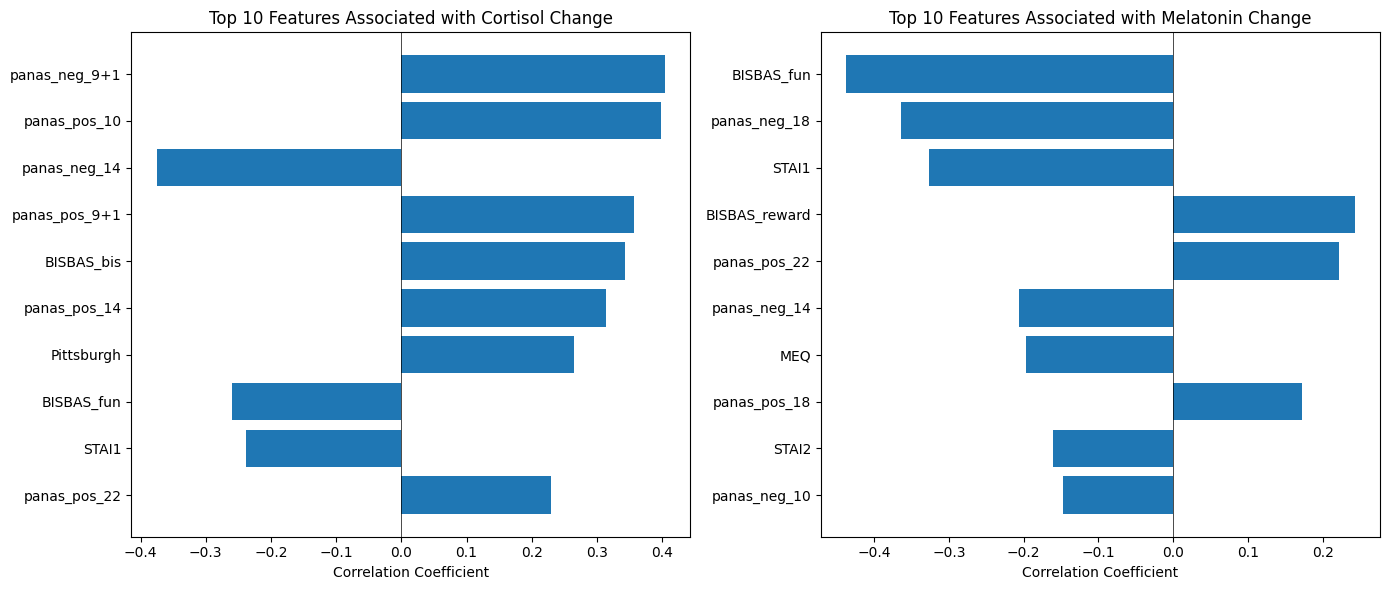


=== CORRELATION ANALYSIS ===
(More appropriate for n=21 samples)

=== TOP CORRELATIONS WITH CORTISOL CHANGE ===
      Feature  Correlation  P-value Significant
panas_neg_9+1     0.404257 0.069127          No
 panas_pos_10     0.398686 0.073420          No
 panas_neg_14    -0.375281 0.093667          No
panas_pos_9+1     0.356160 0.113043          No
   BISBAS_bis     0.342556 0.128489          No
 panas_pos_14     0.313285 0.166711          No
   Pittsburgh     0.264032 0.247466          No
   BISBAS_fun    -0.259441 0.256087          No
        STAI1    -0.238062 0.298725          No
 panas_pos_22     0.229793 0.316317          No

=== SIGNIFICANT CORRELATIONS WITH CORTISOL (p < 0.05) ===
No statistically significant correlations found

=== TOP CORRELATIONS WITH MELATONIN CHANGE ===
      Feature  Correlation  P-value Significant
   BISBAS_fun    -0.437620 0.047257         Yes
 panas_neg_18    -0.364237 0.104533          No
        STAI1    -0.326410 0.148708          No
BISBAS_rewar

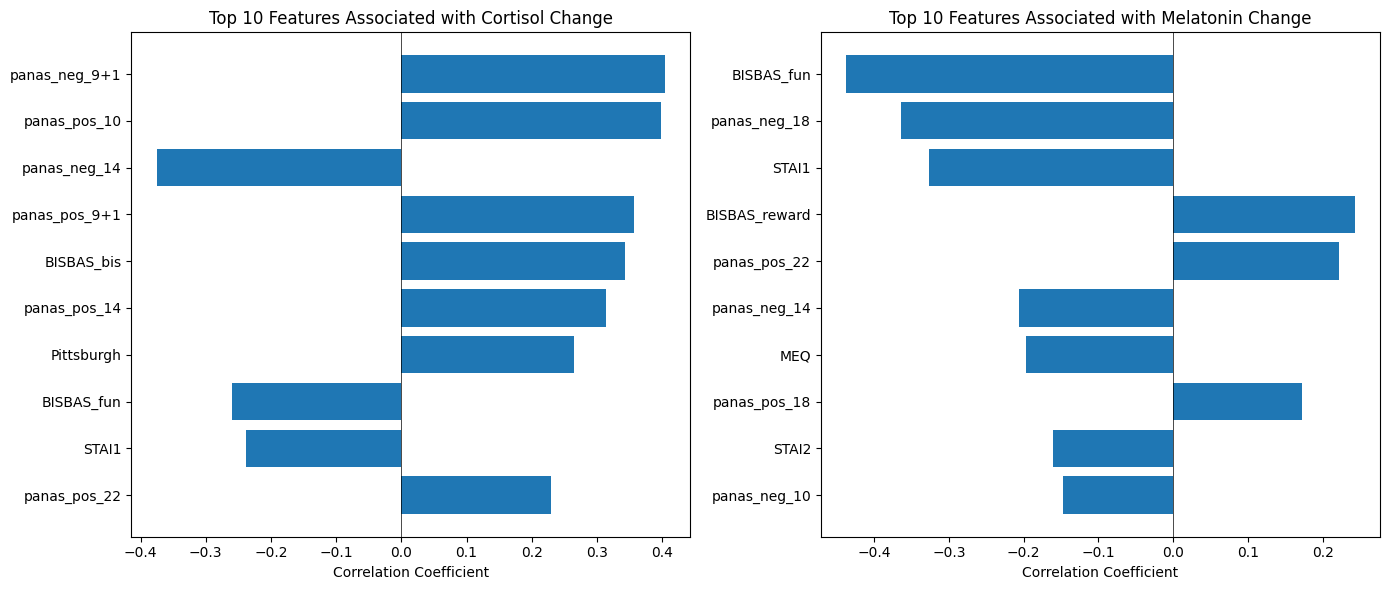

In [21]:
# Correlation Analysis - better suited for small datasets
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

print("\n=== CORRELATION ANALYSIS ===")
print("(More appropriate for n=21 samples)")

# Compute correlations for all features
correlations_cortisol = []
correlations_melatonin = []

for feature in X.columns:
    # Cortisol
    corr_c, p_c = pearsonr(X[feature], y_cortisol)
    correlations_cortisol.append({
        'Feature': feature,
        'Correlation': corr_c,
        'P-value': p_c,
        'Significant': 'Yes' if p_c < 0.05 else 'No'
    })
    
    # Melatonin
    corr_m, p_m = pearsonr(X[feature], y_melatonin)
    correlations_melatonin.append({
        'Feature': feature,
        'Correlation': corr_m,
        'P-value': p_m,
        'Significant': 'Yes' if p_m < 0.05 else 'No'
    })

# Convert to DataFrames and sort by absolute correlation
df_corr_c = pd.DataFrame(correlations_cortisol).sort_values('Correlation', key=abs, ascending=False)
df_corr_m = pd.DataFrame(correlations_melatonin).sort_values('Correlation', key=abs, ascending=False)

print("\n=== TOP CORRELATIONS WITH CORTISOL CHANGE ===")
print(df_corr_c.head(10).to_string(index=False))

print("\n=== SIGNIFICANT CORRELATIONS WITH CORTISOL (p < 0.05) ===")
sig_c = df_corr_c[df_corr_c['Significant'] == 'Yes']
if len(sig_c) > 0:
    print(sig_c.to_string(index=False))
else:
    print("No statistically significant correlations found")

print("\n=== TOP CORRELATIONS WITH MELATONIN CHANGE ===")
print(df_corr_m.head(10).to_string(index=False))

print("\n=== SIGNIFICANT CORRELATIONS WITH MELATONIN (p < 0.05) ===")
sig_m = df_corr_m[df_corr_m['Significant'] == 'Yes']
if len(sig_m) > 0:
    print(sig_m.to_string(index=False))
else:
    print("No statistically significant correlations found")

# Visualize top correlations
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Cortisol
top_features_c = df_corr_c.head(10)
axes[0].barh(top_features_c['Feature'], top_features_c['Correlation'])
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_xlabel('Correlation Coefficient')
axes[0].set_title('Top 10 Features Associated with Cortisol Change')
axes[0].invert_yaxis()

# Melatonin
top_features_m = df_corr_m.head(10)
axes[1].barh(top_features_m['Feature'], top_features_m['Correlation'])
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Correlation Coefficient')
axes[1].set_title('Top 10 Features Associated with Melatonin Change')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Correlation Analysis - better suited for small datasets
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

print("\n=== CORRELATION ANALYSIS ===")
print("(More appropriate for n=21 samples)")

# Compute correlations for all features
correlations_cortisol = []
correlations_melatonin = []

for feature in X.columns:
    # Cortisol
    corr_c, p_c = pearsonr(X[feature], y_cortisol)
    correlations_cortisol.append({
        'Feature': feature,
        'Correlation': corr_c,
        'P-value': p_c,
        'Significant': 'Yes' if p_c < 0.05 else 'No'
    })
    
    # Melatonin
    corr_m, p_m = pearsonr(X[feature], y_melatonin)
    correlations_melatonin.append({
        'Feature': feature,
        'Correlation': corr_m,
        'P-value': p_m,
        'Significant': 'Yes' if p_m < 0.05 else 'No'
    })

# Convert to DataFrames and sort by absolute correlation
df_corr_c = pd.DataFrame(correlations_cortisol).sort_values('Correlation', key=abs, ascending=False)
df_corr_m = pd.DataFrame(correlations_melatonin).sort_values('Correlation', key=abs, ascending=False)

print("\n=== TOP CORRELATIONS WITH CORTISOL CHANGE ===")
print(df_corr_c.head(10).to_string(index=False))

print("\n=== SIGNIFICANT CORRELATIONS WITH CORTISOL (p < 0.05) ===")
sig_c = df_corr_c[df_corr_c['Significant'] == 'Yes']
if len(sig_c) > 0:
    print(sig_c.to_string(index=False))
else:
    print("No statistically significant correlations found")

print("\n=== TOP CORRELATIONS WITH MELATONIN CHANGE ===")
print(df_corr_m.head(10).to_string(index=False))

print("\n=== SIGNIFICANT CORRELATIONS WITH MELATONIN (p < 0.05) ===")
sig_m = df_corr_m[df_corr_m['Significant'] == 'Yes']
if len(sig_m) > 0:
    print(sig_m.to_string(index=False))
else:
    print("No statistically significant correlations found")

# Visualize top correlations
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Cortisol
top_features_c = df_corr_c.head(10)
axes[0].barh(top_features_c['Feature'], top_features_c['Correlation'])
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_xlabel('Correlation Coefficient')
axes[0].set_title('Top 10 Features Associated with Cortisol Change')
axes[0].invert_yaxis()

# Melatonin
top_features_m = df_corr_m.head(10)
axes[1].barh(top_features_m['Feature'], top_features_m['Correlation'])
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Correlation Coefficient')
axes[1].set_title('Top 10 Features Associated with Melatonin Change')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()